# Image Correspondences

In this notebook, we explore different stages to establish robust image correspondences. Please show all generated images in the Jupyter notebook, and not save it on disk.

## Task 1 - Corner Detection and Non-Max Suppression

Load the two given images (mountain1.jpg and mountain2.jpg) and convert them to grayscale.
Use Harris corner detection with parameter `k = 0.05` on each image. Apply a non-max suppression to get the best 200 corners for image correspondences search. You may use the all-in-one function
``goodFeaturesToTrack`` from OpenCV, but you have to comment on each parameter why you need to set it to the corresponding value.

Further on, discard points that are closer than 20 pixel to the image border.
Visualize the resulting points on top of both input images (for instance by drawing a circle at each corner location via ``cv.circle``, or ``cv.drawMarker``).

Tip: For easier handling of the extracted points, feel free to convert the returned multi-dimensional numpy array from goodFeaturesToTrack to a 2-dimensional integer array or list, the first dimension holding the points, the second the x and y pixel coordinates.

Check documentation of ``numpy.astype, numpy.squeeze`` and standard python list ``append``

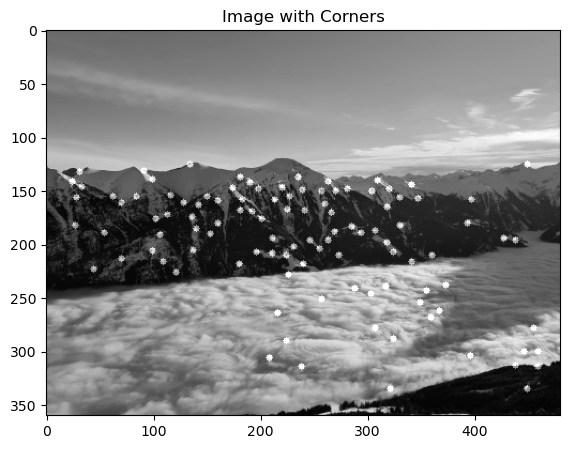

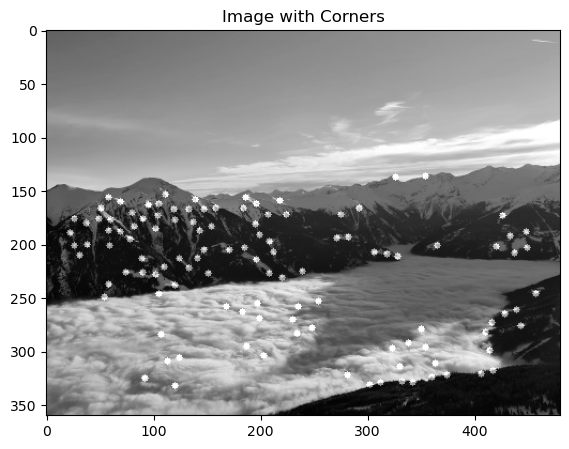

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def loadImage(path, resizeFactor):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    height, width = image.shape[:2]  # Get the height and width from the first two elements
    image = cv2.resize(image, (int(width * resizeFactor), int(height * resizeFactor)))
    return image

def showImage(image, corners):
    plt.figure(figsize=(10, 5))
    
    # Display the grayscale image
    plt.imshow(image, cmap='gray')
    plt.title('Image with Corners')

    corners = corners.reshape(-1, 2)
    
    valid_corners = []
    border_distance = 20
    for corner in corners:
        x, y = corner
        if x > border_distance and x < image.shape[1] - border_distance and \
            y > border_distance and y < image.shape[0] - border_distance:
                valid_corners.append(corner)
    
    valid_corners = np.array(valid_corners)

    # Create a blank image for drawing circles
    circle_image = np.zeros_like(image)

    # Plot valid corners as red circles on the blank image
    for corner in valid_corners:
        x, y = map(int, corner)
        cv2.circle(circle_image, (x, y), 3, (255, 0, 0), -1)

    # Overlay the image with circles on the grayscale image
    result_image = cv2.addWeighted(image, 1, circle_image, 0.5, 0)
    
    plt.imshow(result_image, cmap='gray')
    plt.show()

image = loadImage('mountain1.jpg', 1)
image2 = loadImage('mountain2.jpg', 1)

block_size = 2    # Neighborhood size considered for corner detection
aperture_size = 3 # Aperture parameter for the Sobel() operator
k = 0.05           # Harris detector free parameter

corners1 = cv2.goodFeaturesToTrack(image, maxCorners=200, qualityLevel=0.01, minDistance=10,
                                   blockSize=block_size, useHarrisDetector=True, k=k)

corners2 = cv2.goodFeaturesToTrack(image2, maxCorners=200, qualityLevel=0.01, minDistance=10,
                                   blockSize=block_size, useHarrisDetector=True, k=k)

showImage(image.copy(), corners1)
showImage(image2.copy(), corners2)


## Task 2 - Canonical Rotation via Image Moments

Either use the extracted points from task 1, or load the given json files ``mountain1_corner_points.json`` and ``mountain2_corner_points.json`` to get the point locations for the given images.
For each point, calculate a canonical rotation in radians from the image moments $M_{10}$ and $M_{01}$. For this calculation, use a circular region with a diameter of 13 pixel (center pixel + 6 pixel radius). 
Visualize the rotations of each point on top of the input images (for instance via a line pointing to the direction of the image moment).

Attention: Keep in mind while the y axis of an image usually points down, in common math the angle is defined counter-clockwise in a coordinate system where y points up.

Useful functions:
* math.atan2

for drawing:
* cv.circle
* cv.line
* math.sin, math.cos (to calculate x and y component from a given angle)

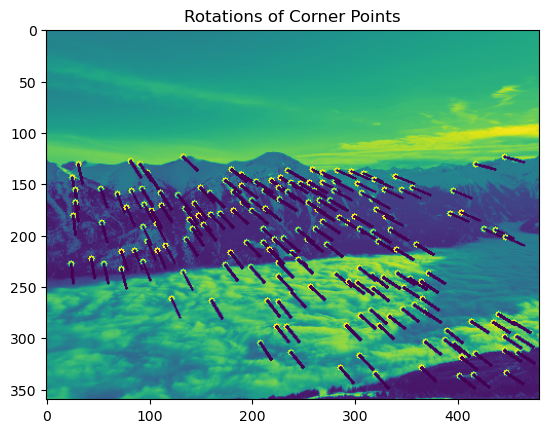

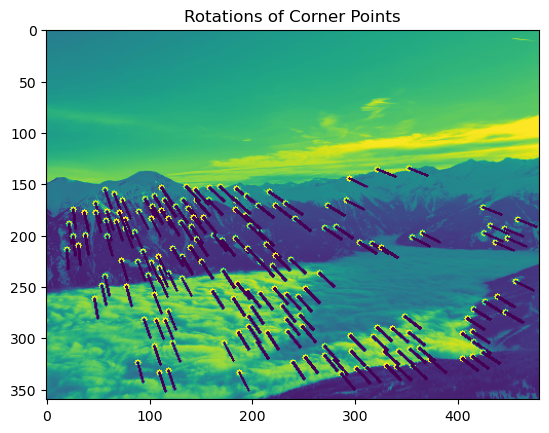

In [2]:
# use this in case you want to load the provided data files
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
with open('mountain1_corner_points.json') as json_file:
    corners1 = json.load(json_file)
with open('mountain2_corner_points.json') as json_file:
    corners2 = json.load(json_file)

import numpy as np
import cv2
from matplotlib import pyplot as plt
import math

def calculateRotationAngle(image, center, radius):
    center = (int(center[0]), int(center[1]))  # Convert center to integers
    mask = np.zeros_like(image, dtype=np.uint8)
    cv2.circle(mask, center, radius, 255, thickness=cv2.FILLED)

    moments = cv2.moments(mask, binaryImage=True)

    rotation_angle = math.atan2(moments['m01'], moments['m10'])

    return rotation_angle

def visualizeRotations(image, points, diameter):
    for point in points:
        rotation_angle = calculateRotationAngle(image, point, diameter // 2)

        line_length = 20
        x_component = int(line_length * math.cos(rotation_angle))
        y_component = int(line_length * math.sin(rotation_angle))

        cv2.circle(image, tuple(point), 3, (255, 0, 0), -1)
        cv2.line(image, tuple(point), (point[0] + x_component, point[1] + y_component), (0, 0, 255), 2)

    plt.imshow(image)
    plt.title('Rotations of Corner Points')
    plt.show()

    # Load the images (assuming you have loaded 'image' and 'image2' earlier)
image = loadImage('mountain1.jpg', 1)
image2 = loadImage('mountain2.jpg', 1)


# Visualize rotations for the first image
visualizeRotations(image.copy(), corners1, diameter=13)

# Visualize rotations for the second image
visualizeRotations(image2.copy(), corners2, diameter=13)

## Task 3 - Normalized Correlation Coefficient and Matching Score Ratio

Use the extracted corner points and their canonical rotations from task 1 and 2, or load the given json files  ``mountain1_corner_points.json``, ``mountain2_corner_points.json``,  ``mountain1_rotations.json`` and ``mountain2_rotations.json``.

Implement a normalized correlation coefficient matching function and match each point of the first input image against each point of the second input image as a 13x13 patch. Make sure the rotations of the patches align before matching. You can use the given function ``extract_rotated_patches``, which extracts and rotates patches from an input image according to the given center points and rotation array. (The elements of the two arrays must align. The function expects angles in radians as counter-clockwise rotation.)

Visualize the best matches of each point of image 1 to image 2. You can use the openCV function ``cv.drawMatches``, but make sure to convert the data accordingly to ``cv.KeyPoint`` and ``cv.DMatch`` array structures. For more information, check the documentation of cv.DrawMatches.

Adjust your matching function to also remember the second best match. Based on the ratio between the second best and the best matching score, discard all points that have a matching ratio above 0.9 and a best score below 0.8. Visualize again the remaining matches between the two images and print in the console the number of remaining matches.

Useful functions:
* numpy.mean() (you can use this function for calculating the mean of a patch)
* cv.drawMatches

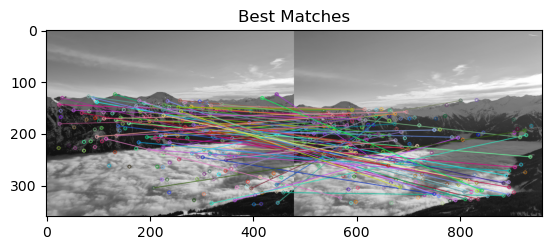

Number of remaining matches: 82


In [3]:
## use this in case you want to load the provided data files
# import json
# class NpEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.integer):
#             return int(obj)
#         if isinstance(obj, np.floating):
#             return float(obj)
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return json.JSONEncoder.default(self, obj)
# with open('mountain1_corner_points.json') as json_file:
#     corners1 = json.load(json_file)
# with open('mountain1_rotations.json') as json_file:
#     rotations1 = json.load(json_file)
# with open('mountain2_corner_points.json') as json_file:
#     corners2 = json.load(json_file)
# with open('mountain2_rotations.json') as json_file:
#     rotations2 = json.load(json_file)

import cv2 as cv
import math
import numpy as np
from matplotlib import pyplot as plt

# This function returns a list of image patches.
# For each element in the input lists [corner_pts, rotations], one patch is extracted from image with the given patch_size
# Note: the angle values are inverted internally, such that this functions returns patches aligned with 0 degree
def extract_rotated_patches(image, corner_pts, rotations, patch_size):
    patches = []
    half_psz = patch_size // 2
    half_psz2 = half_psz * 2
    for pt, angle in zip(corner_pts, rotations):
        # crop to twice the patch size, rotate, and crop again
        angle_deg = - angle * 180 / math.pi  # invert the angle to rotate the patch "back" to 0 degree
        patch = image[pt[1] - half_psz2 : pt[1] + half_psz2 + 1,
                      pt[0] - half_psz2 : pt[0] + half_psz2 + 1]
        rotation_mat = cv.getRotationMatrix2D([half_psz2, half_psz2], angle_deg, scale=1)
        rotated_patch = cv.warpAffine(patch, rotation_mat, patch.shape[0:2])
        rotated_patch = rotated_patch[half_psz:half_psz+patch_size, half_psz:half_psz+patch_size]
        patches.append(rotated_patch)
    return patches


def normalized_correlation(patch1, patch2):
    patch1 = (patch1 - np.mean(patch1)) / (np.std(patch1) * len(patch1))
    patch2 = (patch2 - np.mean(patch2)) / (np.std(patch2) * len(patch2))

    correlation = np.sum(patch1 * patch2)

    return correlation

def match_points(image1, centers1, rotations1, image2, centers2, rotations2, patch_size):
    matched_points = []

    patches1 = extract_rotated_patches(image1, centers1, rotations1, patch_size)
    patches2 = extract_rotated_patches(image2, centers2, rotations2, patch_size)

    for i, patch1 in enumerate(patches1):
        best_correlation = -1
        best_index = -1
        second_best_correlation = -1

        for j, patch2 in enumerate(patches2):
            correlation = normalized_correlation(patch1, patch2)

            if correlation > best_correlation:
                second_best_correlation = best_correlation
                best_correlation = correlation
                best_index = j

        # Calculate the matching ratio
        matching_ratio = second_best_correlation / best_correlation

        # Discard points based on the matching ratio and best score
        if matching_ratio < 0.9 and best_correlation > 0.8:
            matched_points.append((centers1[i], centers2[best_index]))

    return matched_points

def visualize_matches(image1, centers1, image2, centers2, matched_points):
    kp1 = [cv.KeyPoint(center[0], center[1], 1) for center in centers1]
    kp2 = [cv.KeyPoint(center[0], center[1], 1) for center in centers2]

    matches = [cv2.DMatch(i, i, 0) for i in range(len(matched_points))]

    matched_image = cv.drawMatches(image1, kp1, image2, kp2, matches, None)

    plt.imshow(matched_image)
    plt.title('Best Matches')
    plt.show()

image1 = loadImage('mountain1.jpg', 1)
image2 = loadImage('mountain2.jpg', 1)
rotations1 = np.zeros(len(corners1))  # Assuming initial rotations are zero
rotations2 = np.zeros(len(corners2))  # Assuming initial rotations are zero

patch_size = 13
matched_points = match_points(image1, corners1, rotations1, image2, corners2, rotations2, patch_size)

visualize_matches(image1, corners1, image2, corners2, matched_points)

print(f"Number of remaining matches: {len(matched_points)}")